# Download the Dataset

Download the dataset from this link: https://www.kaggle.com/shanwizard/modest-museum-dataset

## Dataset Description

Description of the contents of the dataset can be found here: https://shan18.github.io/MODEST-Museum-Dataset

### Mount Google Drive (Works only on Google Colab)

For running the notebook on Google Colab, upload the dataset into you Google Drive and execute the two cells below

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Unzip the data from Google Drive into Colab

In [0]:
!unzip -qq '/content/gdrive/My Drive/modest_museum_dataset.zip' -d .

### Check GPU

In [0]:
!nvidia-smi

Mon May 25 03:45:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Packages

In [0]:
!pip install -r requirements.txt

# Import Packages

In [0]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import torch

from tensornet.data import MODESTMuseum
from tensornet.utils import initialize_cuda, plot_metric
from tensornet.model import DSResNet
from tensornet.model.optimizer import sgd
from tensornet.engine import LRFinder
from tensornet.engine.ops import ModelCheckpoint, TensorBoard
from tensornet.engine.ops.lr_scheduler import reduce_lr_on_plateau
from loss import RmseBceDiceLoss, SsimDiceLoss
from learner import ModelLearner

# Set Seed and Get GPU Availability

In [0]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)

GPU Available? True


# Data Visualization

In [0]:
DATASET_PATH = 'modest_museum_dataset'

# Common parameter values for the dataset
dataset_params = dict(
    cuda=cuda,
    num_workers=16,
    path=DATASET_PATH,
    hue_saturation_prob=0.25,
    contrast_prob=0.25,
)

In [0]:
%%time
# Create dataset
dataset = MODESTMuseum(
    train_batch_size=256,
    val_batch_size=256,
    resize=(96, 96),
    **dataset_params
)

# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

CPU times: user 8 s, sys: 578 ms, total: 8.58 s
Wall time: 8.58 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


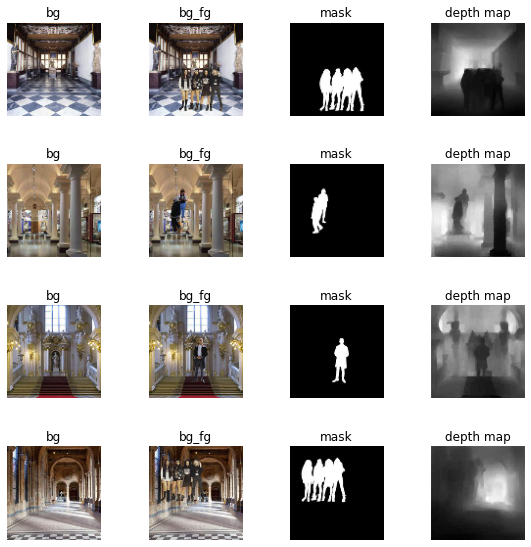

In [0]:
# Set number of data-points to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    idx = random.randint(0, len(dataset.val_data))

    # Background
    axs[i][0].axis('off')
    axs[i][0].set_title('bg')
    axs[i][0].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg'],
        transpose=True, data_type='bg'
    ))

    # Background-Foreground
    axs[i][1].axis('off')
    axs[i][1].set_title('bg_fg')
    axs[i][1].imshow(dataset.unnormalize(
        dataset.val_data[idx][0]['bg_fg'],
        transpose=True, data_type='bg_fg'
    ))

    # Mask
    axs[i][2].axis('off')
    axs[i][2].set_title('mask')
    axs[i][2].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['bg_fg_mask'],
        transpose=True, data_type='bg_fg_mask'
    ).squeeze(), cmap='gray')

    # Depth Map
    axs[i][3].axis('off')
    axs[i][3].set_title('depth map')
    axs[i][3].imshow(dataset.unnormalize(
        dataset.val_data[idx][1]['bg_fg_depth_map'],
        transpose=True, data_type='bg_fg_depth_map'
    ).squeeze(), cmap='gray')

# Model Architecture and Summary

In [0]:
%%time
model = DSResNet().to(device)
model.summary({
    k: v for k, v in dataset.image_size.items() if k in ['bg', 'bg_fg']
})

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]              64
            Conv2d-2         [-1, 16, 224, 224]             448
              ReLU-3         [-1, 16, 224, 224]               0
       BatchNorm2d-4         [-1, 16, 224, 224]              32
            Conv2d-5         [-1, 16, 224, 224]           2,320
              ReLU-6         [-1, 16, 224, 224]               0
       BatchNorm2d-7         [-1, 16, 224, 224]              32
   DoubleConvBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
  ResEncoderBlock-10  [[-1, 16, 112, 112], [-1, 16, 224, 224]]               0
           Conv2d-11         [-1, 32, 112, 112]             544
           Conv2d-12         [-1, 32, 112, 112]           4,640
             ReLU-13         [-1, 32, 112, 112]               0
      BatchNorm2d-14    

# Find Initial Learning Rate

Multiple LR Range Test are done on the model to find the best initial learning rate.

## Range Test 1

In [0]:
model = DSResNet().to(device)  # Create model
optimizer = sgd(model, 1e-7, 0.9)  # Create optimizer
criterion = RmseBceDiceLoss()  # Create loss function

# Find learning rate
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, 400, learner=ModelLearner, start_lr=1e-7, end_lr=5, step_mode='exp')

Iterations
399/400 [======>.] - ETA: 0s - lr: 0.0738 - Loss: 2.2148 
Stopping early, the loss has diverged.
400/400 [========] - 271s 677ms/step - lr: 0.0743 - Loss: 2.2103
Learning rate search finished.


Learning Rate: 0.2804706226423061
Loss: 0.39172855019569397


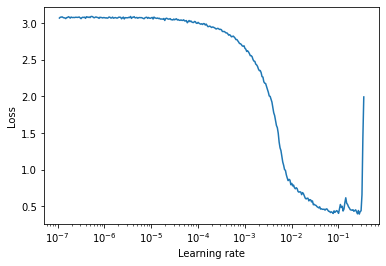

In [0]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

# Print learning rate and loss
print('Learning Rate:', initial_lr)
print('Loss:', lr_finder.best_metric)

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

## Range Test 2

In [0]:
model = DSResNet().to(device)  # Create model
optimizer = sgd(model, 1e-5, 0.9)  # Create optimizer
criterion = RmseBceDiceLoss()  # Create loss function

# Find learning rate
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, 400, learner=ModelLearner, start_lr=1e-5, end_lr=1, step_mode='exp')

Iterations
399/400 [======>.] - ETA: 0s - lr: 0.0348 - Loss: 2.0495 
Stopping early, the loss has diverged.
400/400 [========] - 259s 648ms/step - lr: 0.0350 - Loss: 2.0451
Learning rate search finished.


Learning Rate: 0.10901844923851275
Loss: 0.29762303829193115


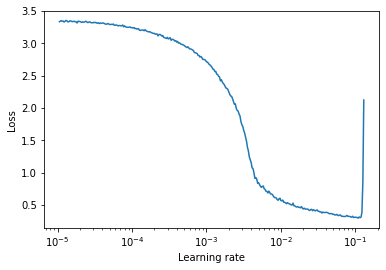

In [0]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

# Print learning rate and loss
print('Learning Rate:', initial_lr)
print('Loss:', lr_finder.best_metric)

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

## Range Test 3

In [0]:
model = DSResNet().to(device)  # Create model
optimizer = sgd(model, 1e-4, 0.9)  # Create optimizer
criterion = RmseBceDiceLoss()  # Create loss function

# Find learning rate
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, 200, learner=ModelLearner, start_lr=1e-4, end_lr=10, step_mode='exp')

Iterations
199/200 [======>.] - ETA: 0s - lr: 0.2032 - Loss: 1.8585 
Stopping early, the loss has diverged.
200/200 [========] - 125s 623ms/step - lr: 0.2044 - Loss: 1.8511
Learning rate search finished.


Learning Rate: 0.4466835921509631
Loss: 0.3652718663215637


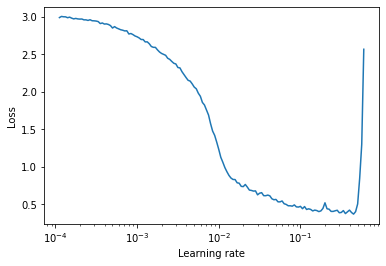

In [0]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

# Print learning rate and loss
print('Learning Rate:', initial_lr)
print('Loss:', lr_finder.best_metric)

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

## Range Test 4

In [0]:
model = DSResNet().to(device)  # Create model
optimizer = sgd(model, 1e-5, 0.9)  # Create optimizer
criterion = RmseBceDiceLoss()  # Create loss function

# Find learning rate
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, 100, learner=ModelLearner, start_lr=1e-5, end_lr=2, step_mode='exp')

Iterations
 99/100 [======>.] - ETA: 0s - lr: 0.0867 - Loss: 3.1983 
Stopping early, the loss has diverged.
100/100 [========] - 75s 753ms/step - lr: 0.0883 - Loss: 3.1749
Learning rate search finished.


Learning Rate: 0.2511047316821864
Loss: 0.8588053584098816


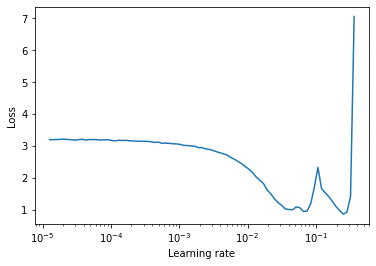

In [0]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

# Print learning rate and loss
print('Learning Rate:', initial_lr)
print('Loss:', lr_finder.best_metric)

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

## Range Test 5

In [0]:
model = DSResNet().to(device)  # Create model
optimizer = sgd(model, 1e-7, 0.9)  # Create optimizer
criterion = RmseBceDiceLoss()  # Create loss function

# Find learning rate
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, 400, learner=ModelLearner, start_lr=1e-7, end_lr=10, step_mode='exp')

Iterations
399/400 [======>.] - ETA: 0s - lr: 0.1034 - Loss: 2.3108 
Stopping early, the loss has diverged.
400/400 [========] - 262s 656ms/step - lr: 0.1038 - Loss: 2.3058
Learning rate search finished.


Learning Rate: 0.28840315031266056
Loss: 0.3179086744785309


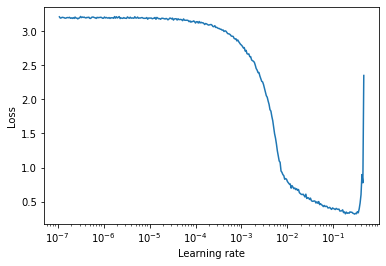

In [0]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

# Print learning rate and loss
print('Learning Rate:', initial_lr)
print('Loss:', lr_finder.best_metric)

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

# LR Finder Results